Importación de librerías:

In [17]:
# Paso 1: Importar bibliotecas
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, ReLU
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K 


# Confirmar que las bibliotecas se importaron correctamente
print("Bibliotecas importadas exitosamente")


Bibliotecas importadas exitosamente


Cargar los datos:

In [2]:
# Leer el archivo CSV y agrega encabezados
columnas = ["Año",  "Trimestre", "Mes", "Semana",  "Región del cliente","Categoría del producto",  "Código del producto", 
            "Demanda del producto", "Precio del producto"]

datos = pd.read_csv('base_pura.csv', sep=';', names=columnas, low_memory=False)
# Ver las primeras filas para asegurarnos de que se ha cargado correctamente
print(datos.head())

    Año  Trimestre  Mes  Semana  Región del cliente  \
0  2024          3    9      36                   1   
1  2024          3    9      36                   1   
2  2024          3    9      36                   1   
3  2024          3    9      36                   1   
4  2024          3    9      36                   1   

           Categoría del producto                       Código del producto  \
0  SNACKS                          300101247                     C00598       
1  LIQUIDOS                        300912666                     C00598       
2  SNACKS                          300914040                     C00598       
3  SNACKS                          300914041                     C00598       
4  INSUMOS OPERACIONALES           400700584                     C00598       

  Demanda del producto  Precio del producto  
0                    1              45289.0  
1                    2               2952.0  
2                    1              19152.0  
3         

Revisar las variables y su tipo. Rellenar vacíos:

In [3]:
# Paso 2.5: Asegurar los tipos de datos, revisar datos faltantes y manejar los datos numéricos faltantes

# 1) Asegurar que las columnas tengan el tipo de dato correcto
# Convertir las columnas numéricas a su tipo adecuado
datos['Demanda del producto'] = pd.to_numeric(datos['Demanda del producto'], errors='coerce')
datos['Precio del producto'] = pd.to_numeric(datos['Precio del producto'], errors='coerce')

# Convertir las columnas categóricas
datos['Código del producto'] = datos['Código del producto'].astype(str)
datos['Categoría del producto'] = datos['Categoría del producto'].astype(str)

# 2) Revisar si hay datos faltantes
# Mostrar el número de valores nulos por cada columna
print("Valores nulos por columna:")
print(datos.isnull().sum())

# 3) Manejar los valores faltantes en las columnas numéricas
# Rellenar los valores faltantes en 'Demanda del producto' y 'Precio del producto' con 0
datos['Demanda del producto'].fillna(0, inplace=True)
datos['Precio del producto'].fillna(0, inplace=True)

# Verificar que no haya valores faltantes después del reemplazo
print("Valores nulos después de rellenar:")
print(datos.isnull().sum())

# Reemplazar demandas negativas por 0
datos['Demanda del producto'] = datos['Demanda del producto'].apply(lambda x: max(0, x))


# Inspeccionar las primeras filas de nuevo para asegurarse de que todo esté en orden
print(datos.head())


Valores nulos por columna:
Año                       0
Trimestre                 0
Mes                       0
Semana                    0
Región del cliente        0
Categoría del producto    0
Código del producto       0
Demanda del producto      3
Precio del producto       0
dtype: int64
Valores nulos después de rellenar:
Año                       0
Trimestre                 0
Mes                       0
Semana                    0
Región del cliente        0
Categoría del producto    0
Código del producto       0
Demanda del producto      0
Precio del producto       0
dtype: int64
    Año  Trimestre  Mes  Semana  Región del cliente  \
0  2024          3    9      36                   1   
1  2024          3    9      36                   1   
2  2024          3    9      36                   1   
3  2024          3    9      36                   1   
4  2024          3    9      36                   1   

           Categoría del producto                       Código del producto  

Creamos un index de fecha

In [4]:
# Paso 2.25: Crear la columna 'Fecha' basada en 'Año' y 'Semana'

# Asegurarnos de que las columnas 'Año' y 'Semana' sean enteros
datos['Año'] = pd.to_numeric(datos['Año'], errors='coerce')
datos['Semana'] = pd.to_numeric(datos['Semana'], errors='coerce')

# Crear la columna 'Fecha' usando el lunes de cada semana ('Semana' y 'Año')
datos['Fecha'] = pd.to_datetime(datos['Año'].astype(str) + datos['Semana'].astype(str) + '1', format='%Y%W%w')

# Inspeccionar las primeras filas para verificar que la fecha se creó correctamente
print(datos[['Año', 'Semana', 'Fecha']].head())


    Año  Semana      Fecha
0  2024      36 2024-09-02
1  2024      36 2024-09-02
2  2024      36 2024-09-02
3  2024      36 2024-09-02
4  2024      36 2024-09-02


Hacemos un subconjunto de los productos activos:

In [5]:
# Paso 2.75: Filtrar productos con demanda en los últimos 3 meses

# Determinar la fecha más reciente en los datos
fecha_maxima = datos['Fecha'].max()

# Calcular la fecha límite (3 meses antes de la fecha más reciente)
fecha_limite = fecha_maxima - pd.DateOffset(months=3)

# Filtrar los productos que han tenido demanda en los últimos 3 meses
productos_recientes = datos[datos['Fecha'] >= fecha_limite]

# Verificar los datos filtrados
print(f"Fecha límite: {fecha_limite}")
print(f"Cantidad de productos con demanda en los últimos 3 meses: {productos_recientes['Código del producto'].nunique()}")
print(productos_recientes.head())


Fecha límite: 2024-06-09 00:00:00
Cantidad de productos con demanda en los últimos 3 meses: 1322
    Año  Trimestre  Mes  Semana  Región del cliente  \
0  2024          3    9      36                   1   
1  2024          3    9      36                   1   
2  2024          3    9      36                   1   
3  2024          3    9      36                   1   
4  2024          3    9      36                   1   

           Categoría del producto                       Código del producto  \
0  SNACKS                          300101247                     C00598       
1  LIQUIDOS                        300912666                     C00598       
2  SNACKS                          300914040                     C00598       
3  SNACKS                          300914041                     C00598       
4  INSUMOS OPERACIONALES           400700584                     C00598       

   Demanda del producto  Precio del producto      Fecha  
0                   1.0              45

Agrupamos usando las variables que nos interesan:

In [6]:
# Paso 3: Agrupar los datos filtrados por Código del producto, Año y Semana
productos_agrupados = productos_recientes.groupby(['Código del producto', 'Año', 'Semana', 'Fecha']).agg({
    'Demanda del producto': 'sum',  # Sumar la demanda para cada semana-año
    'Mes': 'first',  # Tomar el primer valor del mes
    'Categoría del producto': 'first',  # Tomar el primer valor de la categoría
}).reset_index()

# Asegurarnos de que las columnas categóricas sean numéricas
label_encoder_categoria = LabelEncoder()
productos_agrupados['Categoría del producto'] = label_encoder_categoria.fit_transform(productos_agrupados['Categoría del producto'])

# Verificar que los datos se hayan procesado correctamente
print(productos_agrupados.head(20))


                         Código del producto   Año  Semana      Fecha  \
0   100200545                     C00598      2024      24 2024-06-10   
1   100200545                     C00598      2024      25 2024-06-17   
2   100200545                     C00598      2024      26 2024-06-24   
3   100200545                     C00598      2024      30 2024-07-22   
4   100200545                     C00598      2024      33 2024-08-12   
5   100200545                     C00598      2024      34 2024-08-19   
6   100200545                     C00598      2024      36 2024-09-02   
7   100200902                     C00598      2024      24 2024-06-10   
8   100200902                     C00598      2024      25 2024-06-17   
9   100200902                     C00598      2024      26 2024-06-24   
10  100200902                     C00598      2024      27 2024-07-01   
11  100200902                     C00598      2024      28 2024-07-08   
12  100200902                     C00598      2024 

Revisamos el comportamiento de la demanda

count    13329.000000
mean        57.515718
std        146.288415
min          1.000000
25%          5.000000
50%         14.000000
75%         45.000000
max       2529.000000
Name: Demanda del producto, dtype: float64
Valores nulos: 0
Valores iguales a cero: 0
Valores únicos: 647
Percentiles de la demanda:
0.25      5.00
0.50     14.00
0.75     45.00
0.95    260.00
0.99    723.88
Name: Demanda del producto, dtype: float64


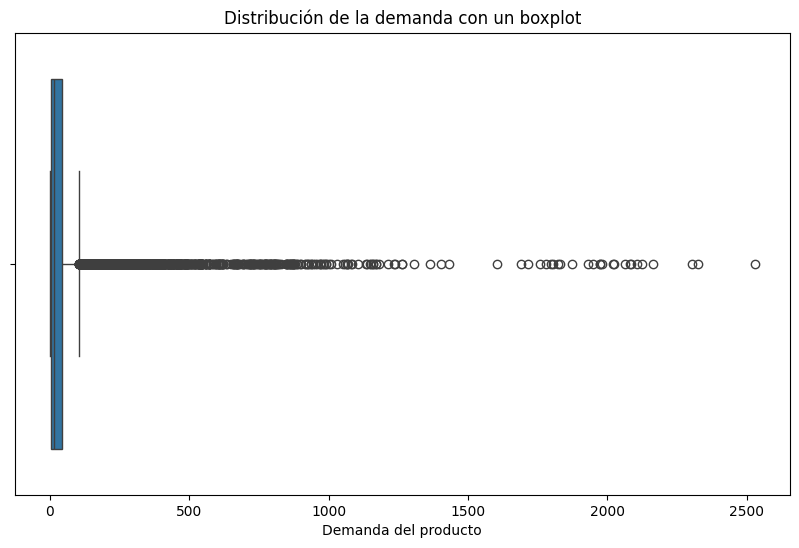

In [7]:
# Obtener estadísticas descriptivas básicas de la columna 'Demanda del producto'
estadisticos = productos_agrupados['Demanda del producto'].describe()

# Imprimir estadísticas básicas
print(estadisticos)

# Revisar la cantidad de valores únicos, nulos y cero en la columna 'Demanda del producto'
valores_nulos = productos_agrupados['Demanda del producto'].isnull().sum()
valores_cero = (productos_agrupados['Demanda del producto'] == 0).sum()
valores_unicos = productos_agrupados['Demanda del producto'].nunique()

print(f"Valores nulos: {valores_nulos}")
print(f"Valores iguales a cero: {valores_cero}")
print(f"Valores únicos: {valores_unicos}")

# Mostrar percentiles específicos para entender la distribución
percentiles = productos_agrupados['Demanda del producto'].quantile([0.25, 0.5, 0.75, 0.95, 0.99])
print("Percentiles de la demanda:")
print(percentiles)

# Verificar la presencia de outliers visualmente con un boxplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=productos_agrupados['Demanda del producto'])
plt.title('Distribución de la demanda con un boxplot')
plt.show()


Escalamos la demanda:

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Escalar los datos entre [1, 100] después de eliminar valores negativos
scaler = MinMaxScaler(feature_range=(1,100)) #ITERABLE

# Ajustar el escalador a los datos de demanda originales
scaler.fit(productos_agrupados[['Demanda del producto']])

# Aplicar el escalador a la columna de demanda
productos_agrupados['Demanda del producto'] = scaler.transform(productos_agrupados[['Demanda del producto']])

# Verificar el mínimo y máximo después de escalar
print("Mínimos usados por el scaler:", scaler.data_min_)
print("Máximos usados por el scaler:", scaler.data_max_)


Mínimos usados por el scaler: [1.]
Máximos usados por el scaler: [2529.]


Creamos las secuencias LSTM:

In [9]:
# Paso 5: Crear secuencias para el modelo LSTM
def crear_secuencias(data, window_size):
    X, y = [], []
    if len(data) > window_size:
        for i in range(len(data) - window_size):
            X.append(data[i:i+window_size])
            y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana de tiempo (cuántas semanas usar para predecir la siguiente semana)
window_size = 12 #HIPERPARÁMETRO

# Crear secuencias
X_list, y_list = [], []
for codigo_producto in productos_agrupados['Código del producto'].unique():
    producto_data = productos_agrupados[productos_agrupados['Código del producto'] == codigo_producto]
    producto_data_lstm = producto_data[['Demanda del producto', 'Mes', 'Categoría del producto']].values
    X_producto, y_producto = crear_secuencias(producto_data_lstm, window_size)
    if len(X_producto) > 0:
        X_list.append(X_producto)
        y_list.append(y_producto)

# Concatenar las secuencias
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")


Shape de X: (1310, 12, 3)
Shape de y: (1310, 3)


Construimos el modelo LSTM:

In [19]:
from tensorflow.keras.optimizers import Adam

# Paso: Crear el modelo LSTM
model = Sequential()
model.add(Input(shape=(X.shape[1], X.shape[2])))
model.add(LSTM(150, return_sequences=True))  #HIPERPARÁMETRO
model.add(LSTM(100, return_sequences=False))  #HIPERPARÁMETRO
model.add(Dropout(0.2))
model.add(Dense(1))

# Agregar ReLU para forzar valores ≥ 0
model.add(ReLU())

# Definir la función de pérdida personalizada
def custom_loss(y_true, y_pred):
    # Calcula el MSE como de costumbre
    mse_loss = K.mean(K.square(y_true - y_pred), axis=-1)
    
    # Penalizar predicciones negativas
    negative_penalty = K.mean(K.relu(-y_pred), axis=-1)
    
    # La pérdida total será la combinación de ambas
    return mse_loss + negative_penalty

# Paso: Ajustar el optimizador con una tasa de aprendizaje más baja
optimizer = Adam(learning_rate=0.0005)  #HIPERPARÁMETRO

# Paso: Compilar el modelo con el optimizador ajustado
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Mostrar resumen del modelo
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 12, 150)        │        92,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,901 (753.52 KB)

 Trainable params: 192,901 (753.52 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos:

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 54.1423 - val_loss: 2.9824
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 38.6500 - val_loss: 0.5079
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 35.1143 - val_loss: 0.4978
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 19.7644 - val_loss: 0.4259
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 25.9527 - val_loss: 0.4707
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 23.6586 - val_loss: 0.4161
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.1321 - val_loss: 0.4757
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 23.5854 - val_loss: 0.5280
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 14.7876 - val_loss: 0.4898
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 17.9325 - val_loss: 0.4811
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 22.6191 - val_loss: 0.4587
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

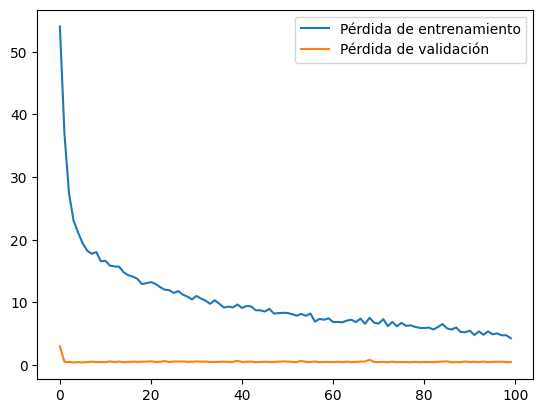

In [20]:
# Paso 7: Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y[:, 0], test_size=0.2, shuffle=False)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))
#HIPERPARÁMETRO

# Graficar el historial de entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend()
plt.show()


In [21]:
# Realizar predicciones con el modelo
y_pred = model.predict(X_test)

# Desescalar las predicciones al rango original
y_pred_original = scaler.inverse_transform(y_pred)

# Mostrar las primeras 10 predicciones desescaladas
for i in range(10):
    print(f'Predicción destransformada: {y_pred_original[i]}')



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicción destransformada: [15.109665]
Predicción destransformada: [28.742151]
Predicción destransformada: [20.185112]
Predicción destransformada: [16.61995]
Predicción destransformada: [8.43407]
Predicción destransformada: [7.86878]
Predicción destransformada: [17.876253]
Predicción destransformada: [10.756879]
Predicción destransformada: [23.35512]
Predicción destransformada: [14.826206]


Finalmente, la predicción de la semana siguiente:

In [22]:
# Paso 1: Encontrar la última semana disponible en los datos
ultima_fecha = productos_agrupados['Fecha'].max()
print(f"Última fecha disponible: {ultima_fecha}")

# Paso 2: Obtener los datos correspondientes a las últimas 4 semanas para cada producto
# Filtrar los datos para obtener solo los productos con datos en las últimas 4 semanas
productos_ultimas_semanas = productos_agrupados[productos_agrupados['Fecha'] >= (ultima_fecha - pd.DateOffset(weeks=4))]

# Paso 3: Crear secuencias de 12 semanas para predecir la siguiente semana
def crear_secuencias_prediccion(data, window_size):
    X = []
    if len(data) >= window_size:
        X.append(data[-window_size:])  # Tomar las últimas 'window_size' semanas
    return np.array(X)

# Lista para almacenar las secuencias de predicción y los códigos de producto
X_pred_list = []
codigos_articulos = []

# Recorrer todos los productos únicos
for codigo_producto in productos_ultimas_semanas['Código del producto'].unique():
    producto_data = productos_ultimas_semanas[productos_ultimas_semanas['Código del producto'] == codigo_producto]
    
    # Tomar las columnas relevantes para el modelo: ['Demanda del producto', 'Mes', 'Categoría del producto']
    producto_data_lstm = producto_data[['Demanda del producto', 'Mes', 'Categoría del producto']].values
    
    # Crear secuencias para la predicción
    X_pred = crear_secuencias_prediccion(producto_data_lstm, window_size=4)
    
    # Si se pudo crear una secuencia válida, almacenarla
    if len(X_pred) > 0:
        X_pred_list.append(X_pred)
        codigos_articulos.append(codigo_producto)

# Concatenar todas las secuencias de predicción
X_pred = np.concatenate(X_pred_list, axis=0)

print(f"Tamaño de X_pred: {X_pred.shape}")

# Paso 4: Predecir la demanda para la semana siguiente
y_pred_semana_siguiente = model.predict(X_pred)

# Desnormalizar las predicciones
y_pred_semana_siguiente_rescaled = scaler.inverse_transform(y_pred_semana_siguiente)

# Paso 5: Crear un DataFrame con las predicciones
siguiente_semana = ultima_fecha + pd.DateOffset(weeks=1)  # Definir la semana siguiente
df_predicciones = pd.DataFrame({
    'Código del producto': codigos_articulos,
    'Semana proyectada': siguiente_semana,
    'Demanda predicha': y_pred_semana_siguiente_rescaled.flatten()
})

# Mostrar las primeras filas del DataFrame de predicciones
print(df_predicciones.head())

# Guardar las predicciones a un archivo CSV (opcional)
df_predicciones.to_csv('predicciones_semana_siguiente.csv', index=False)


Última fecha disponible: 2024-09-09 00:00:00
Tamaño de X_pred: (846, 4, 3)
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                        Código del producto Semana proyectada  \
0  100200902                     C00598            2024-09-16   
1  100201738                     C00598            2024-09-16   
2  100202566                     C00598            2024-09-16   
3  100203197                     C00598            2024-09-16   
4  100204200                     C00598            2024-09-16   

   Demanda predicha  
0         73.791039  
1         16.888517  
2        452.431305  
3         52.550499  
4          4.165241  
